# Replication: Sterling *etal*, 2016
## Introduction

This notebook attempts to replicate the following paper with [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Sterling, Nicholas W, et al. <a href=https://n.neurology.org/content/86/12/1143.short>Stage-dependent loss of cortical gyrification as Parkinson disease “unfolds”.</a> Neurology, vol. 86, no. 12, pp. 1143–1151, Mar. 2016. 
</div>

This study recruited 70 patients with PD without dementia and 70 control participants. Cortical local gyrification index (LGI) was compared between controls and PD subgroups based upon duration of illness. In the longitudinal cohort, PD<sub>L</sub> had significantly reduced overall gyrification, and bilaterally in the inferior parietal, postcentral, precentral, superior frontal, and superamarginal areas, compared to controls (*p* < 0.05). Longitudinally, loss of gyrification was accelerated in PD<sub>M</sub>, compared to controls. Demographic and clinical properties were as follows (table extracted from the paper):

<br>
<img src="demographics.png">

In [46]:
import os
import os.path as op
import math
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import livingpark_utils
from livingpark_utils import download
from livingpark_utils.dataset import ppmi
from livingpark_utils import clinical
from livingpark_utils.visualization import reformat_plot_labels
from collections.abc import Iterable
import rich
import scipy
from rich.console import Console
from rich.table import Table

# Ignore warnings
warnings.filterwarnings("ignore")

# Style the plots
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "none"
plt.rcParams["figure.autolayout"] = True

inputs_dir = os.path.join(os.getcwd(), "inputs/study_files")
outputs_dir = os.path.join(os.getcwd(), "outputs")
data_dir = os.path.join(os.getcwd(), "data")

utils = livingpark_utils.LivingParkUtils()
downloader = download.ppmi.Downloader(utils.study_files_dir)
utils.notebook_init()

This notebook was run on 2023-03-26 22:09:32 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort:

| File | Corresponding parameter |
| :---- | :---- |
| Age at visit | age |
| Demographics | sex |
| Socio Economics | education |
| Participant Status | PD subjects and healthy controls |
| Primary Clinical Diagnosis | subjects with no PD and no other neurological disorder |
| MDS UPDRS Part III | UPDRS III values and H&Y scores |
| Montreal Cognitive Assessment MoCA | MMSE scores |
| PD Diagnosis History | duration of illness (DOI) |
| LEDD Concomitant Medication log | LEDD values |
| Geriatric Depression Scale Short Version | GDS scores |


We will use LivingPark utils library to download these files from the notebook. If the files are already present, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [47]:
required_files = [
    "Age_at_visit.csv",
    "Demographics.csv",
    "Socio-Economics.csv",
    "Participant_Status.csv",
    "Primary_Clinical_Diagnosis.csv",
    "MDS-UPDRS_Part_III.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Geriatric_Depression_Scale__Short_Version_.csv",
]

utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


In [ ]:
from livingpark_utils.scripts import mri_metadata, pd_status

run.mri_metadata()
run.pd_status()

### Cohort matching

### Participants (PD patients and healthy controls)

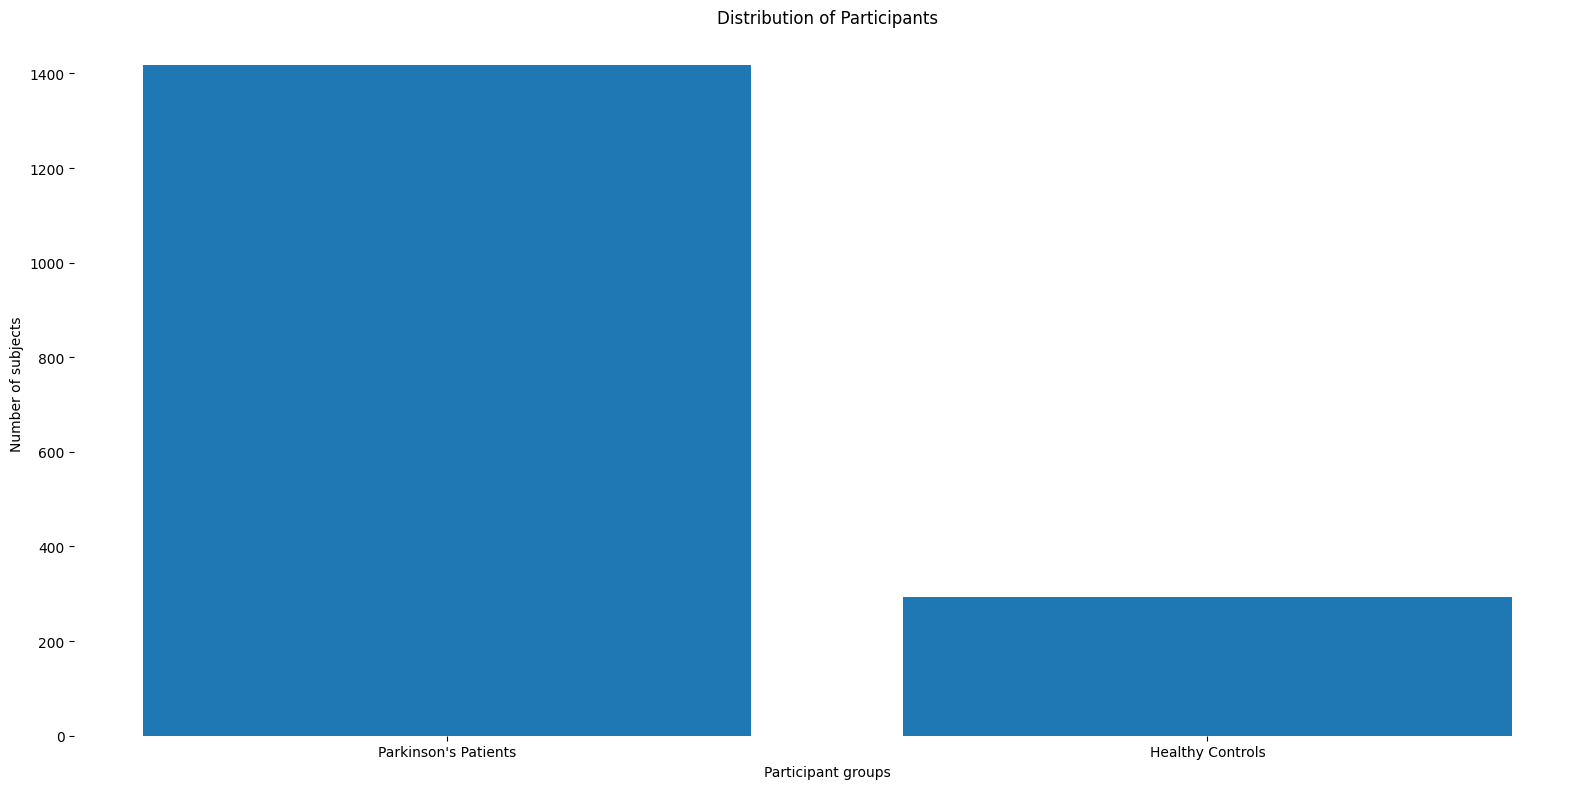

In [48]:
participants = pd.read_csv(os.path.join(inputs_dir, "Participant_Status.csv"))[
    ["PATNO", "COHORT"]
]
# Only keep PD (1) and HC (2)
participants = participants[participants["COHORT"].isin([1, 2])]

pd_patients = participants[participants["COHORT"] == 1]
hc = participants[participants["COHORT"] == 2]

prim_diag = pd.read_csv(os.path.join(inputs_dir, "Primary_Clinical_Diagnosis.csv"))[
    ["PATNO", "PRIMDIAG"]
]
# Only select subjects with no PD nor other neurological disoroder
prim_diag = prim_diag[prim_diag["PRIMDIAG"] == 17]

# Participants are considered healthy control if they have both PRIMADIAG 17 and COHORT 2
hc = hc.merge(prim_diag, on=["PATNO"]).drop(labels=["PRIMDIAG"], axis=1)

participants = pd.concat([pd_patients, hc]).drop_duplicates(subset=["PATNO"])
# participants inplace=True)

dist = participants.groupby(["COHORT"]).size()
plt.bar(["Parkinson's Patients", "Healthy Controls"], dist.values)
plt.title("Distribution of Participants")
plt.xlabel("Participant groups")
plt.ylabel("Number of subjects");

### Duration of illness (DOI)

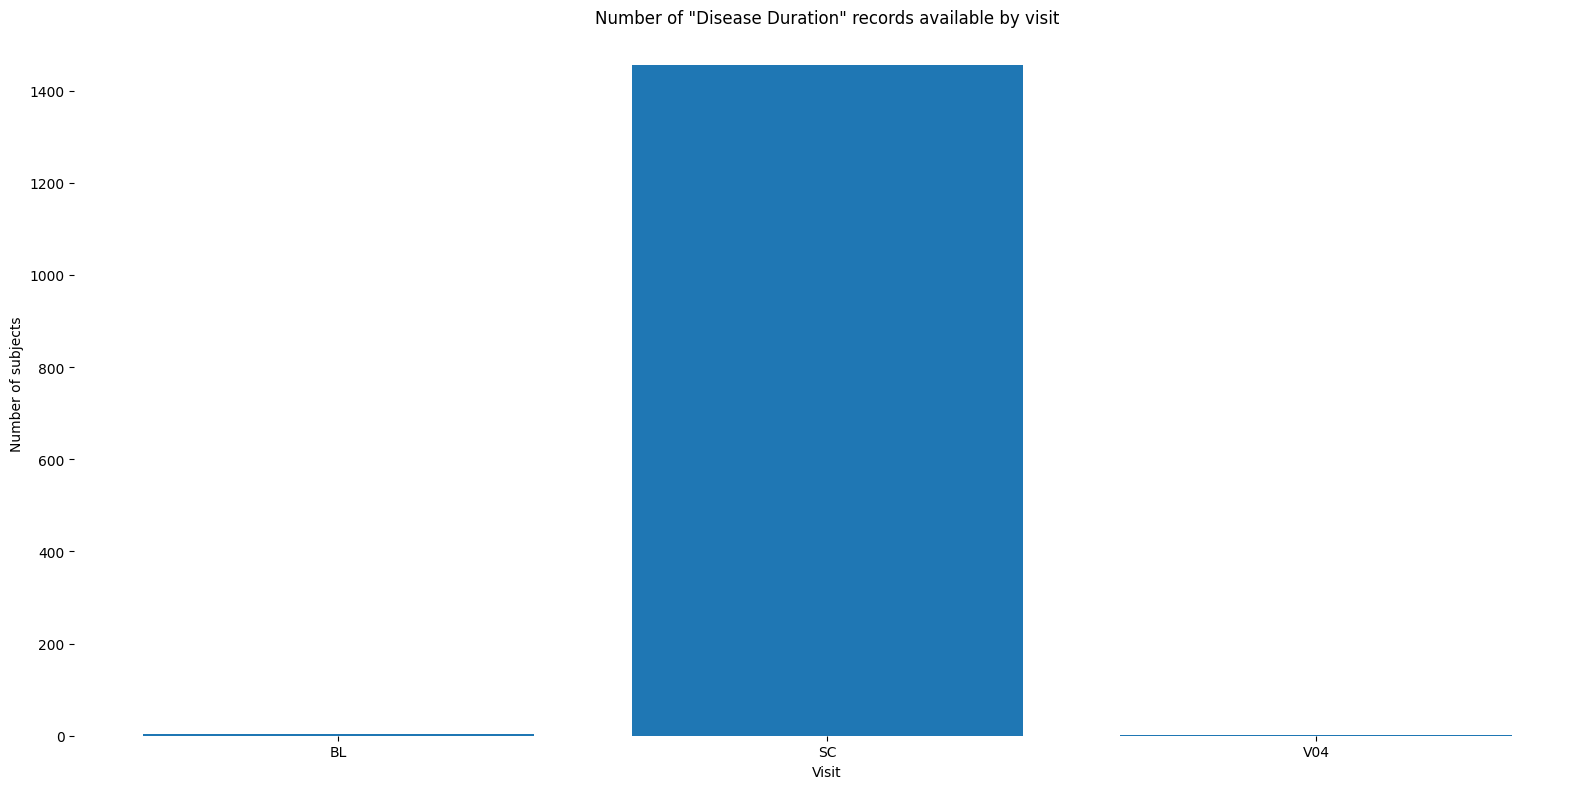

In [49]:
pddxdt = pd.read_csv(os.path.join(inputs_dir, "PD_Diagnosis_History.csv"))[
    ["PATNO", "EVENT_ID", "PDDXDT"]
]

dist = pddxdt.groupby(["EVENT_ID"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title('Number of "Disease Duration" records available by visit')
plt.xlabel("Visit")
plt.ylabel("Number of subjects");

We will only use the PD diagnosis taken at screening since it is by far the most frequent.

In [50]:
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

pddxdt = pddxdt[(pddxdt["EVENT_ID"] == "SC") & (pddxdt["PDDXDT"].notna())]

pdxdur = pd.read_csv(
    os.path.join(inputs_dir, "MDS-UPDRS_Part_III.csv"), low_memory=False
)[["PATNO", "EVENT_ID", "INFODT"]]

PDDXDT_map = dict(zip(pddxdt["PATNO"].values, pddxdt["PDDXDT"].values))
pdxdur["PDDXDT"] = pdxdur["PATNO"].map(PDDXDT_map)

pdxdur["PDXDUR"] = pdxdur.apply(
    lambda row: relativedelta(parse(row["INFODT"]), parse(row["PDDXDT"])).years
    if row["PDDXDT"] is not np.nan
    else np.nan,
    axis=1,
)

pdxdur.drop(labels=["INFODT", "PDDXDT"], inplace=True, axis=1)

### PD subgroups
Study divided PD patients in subgroups based upon duration of illness, defined as the number of years since diagnosis. PD<sub>E</sub> (<1 year), PD<sub>M</sub> (1-5 years), and PD<sub>L</sub> (>5 years).

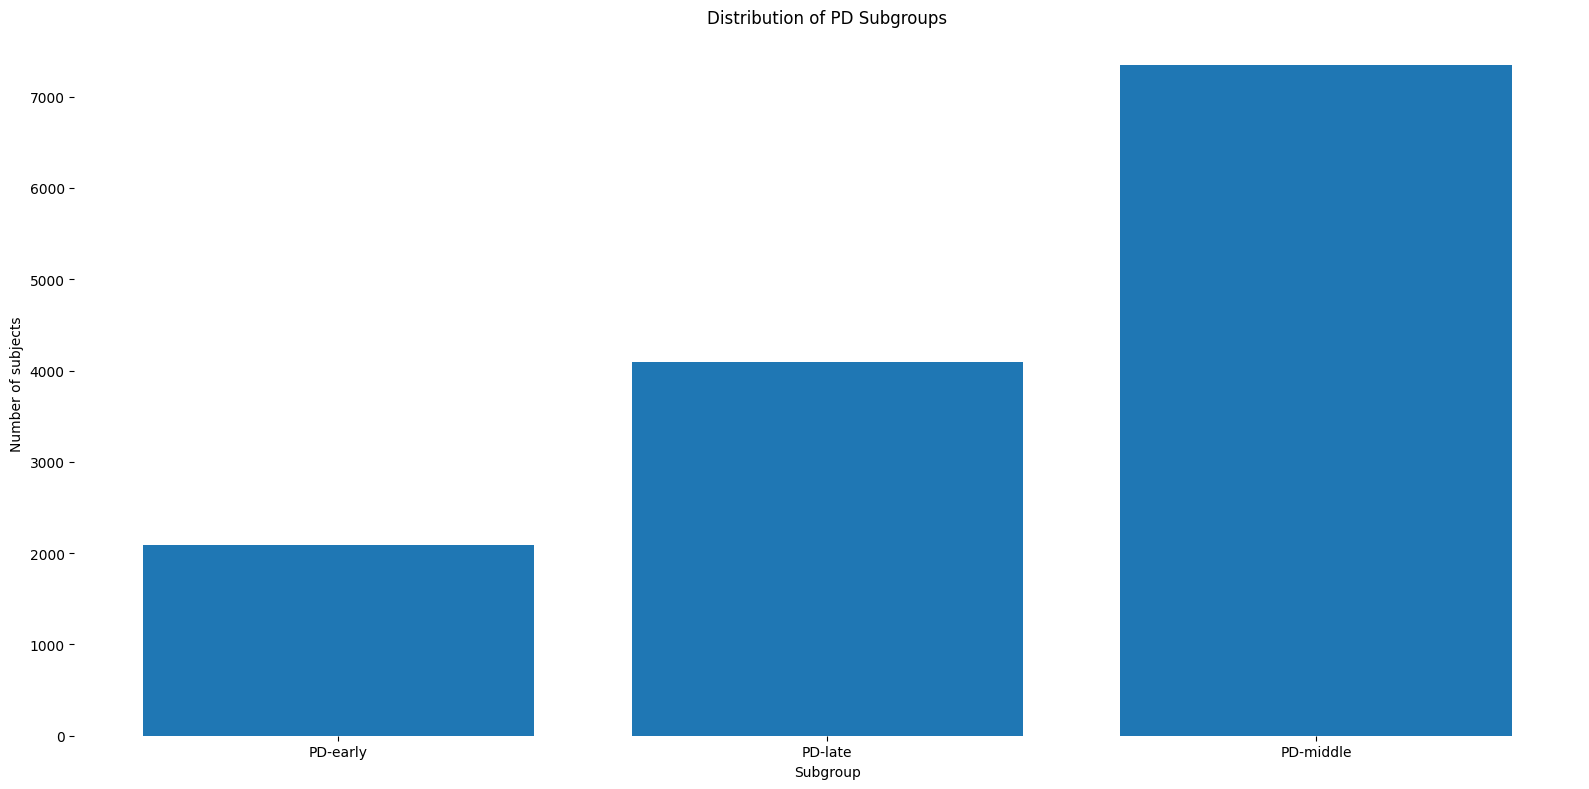

In [51]:
pdxdur["DOI"] = (
    pdxdur["PDXDUR"]
    .mask(pdxdur["PDXDUR"] < 1, "PD-early")
    .mask((pdxdur["PDXDUR"] >= 1) & (pdxdur["PDXDUR"] <= 5), "PD-middle")
    .mask(pdxdur["PDXDUR"] > 5, "PD-late")
)

fig, ax = plt.subplots()
dist = pdxdur.groupby(["DOI"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of PD Subgroups")
plt.xlabel("Subgroup")
plt.ylabel("Number of subjects");

### Examination scores

### Mini-Mental State Examination (MMSE)
The study selected patients with MMSE score ≥26 (without dementia).

0.0


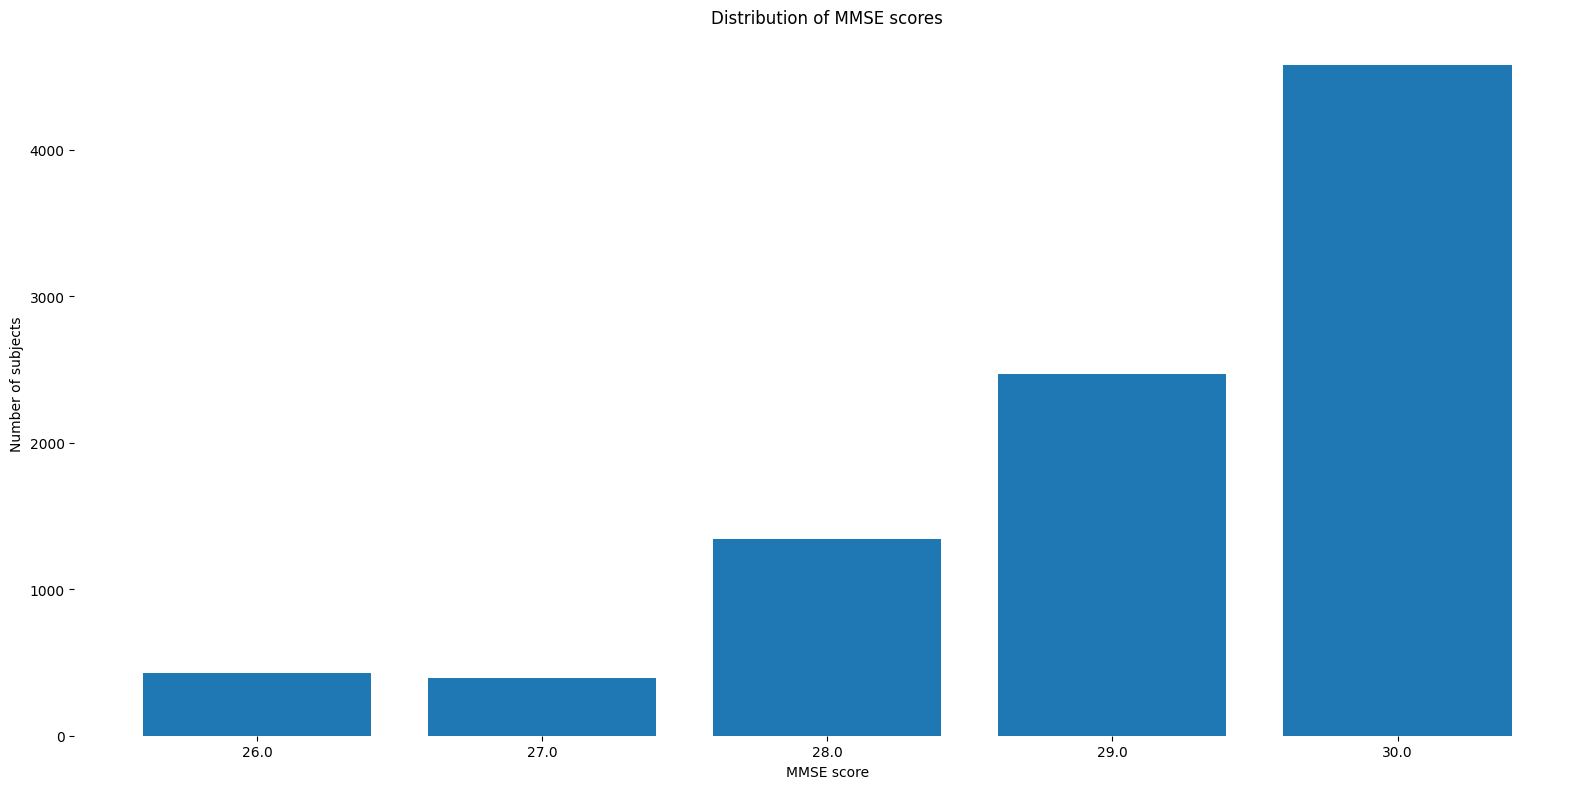

In [52]:
mmse = pd.read_csv(
    os.path.join(inputs_dir, "Montreal_Cognitive_Assessment__MoCA_.csv")
)[["PATNO", "EVENT_ID", "MCATOT"]]
mmse["MMSETOT"] = mmse["MCATOT"].apply(clinical.moca2mmse)
mmse = mmse.drop(["MCATOT"], axis=1)
mmse = mmse[mmse["MMSETOT"] >= 26]

dist = mmse.groupby(["MMSETOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MMSE scores")
plt.xlabel("MMSE score")
plt.ylabel("Number of subjects");

### Hoehn & Yahr (H&Y)

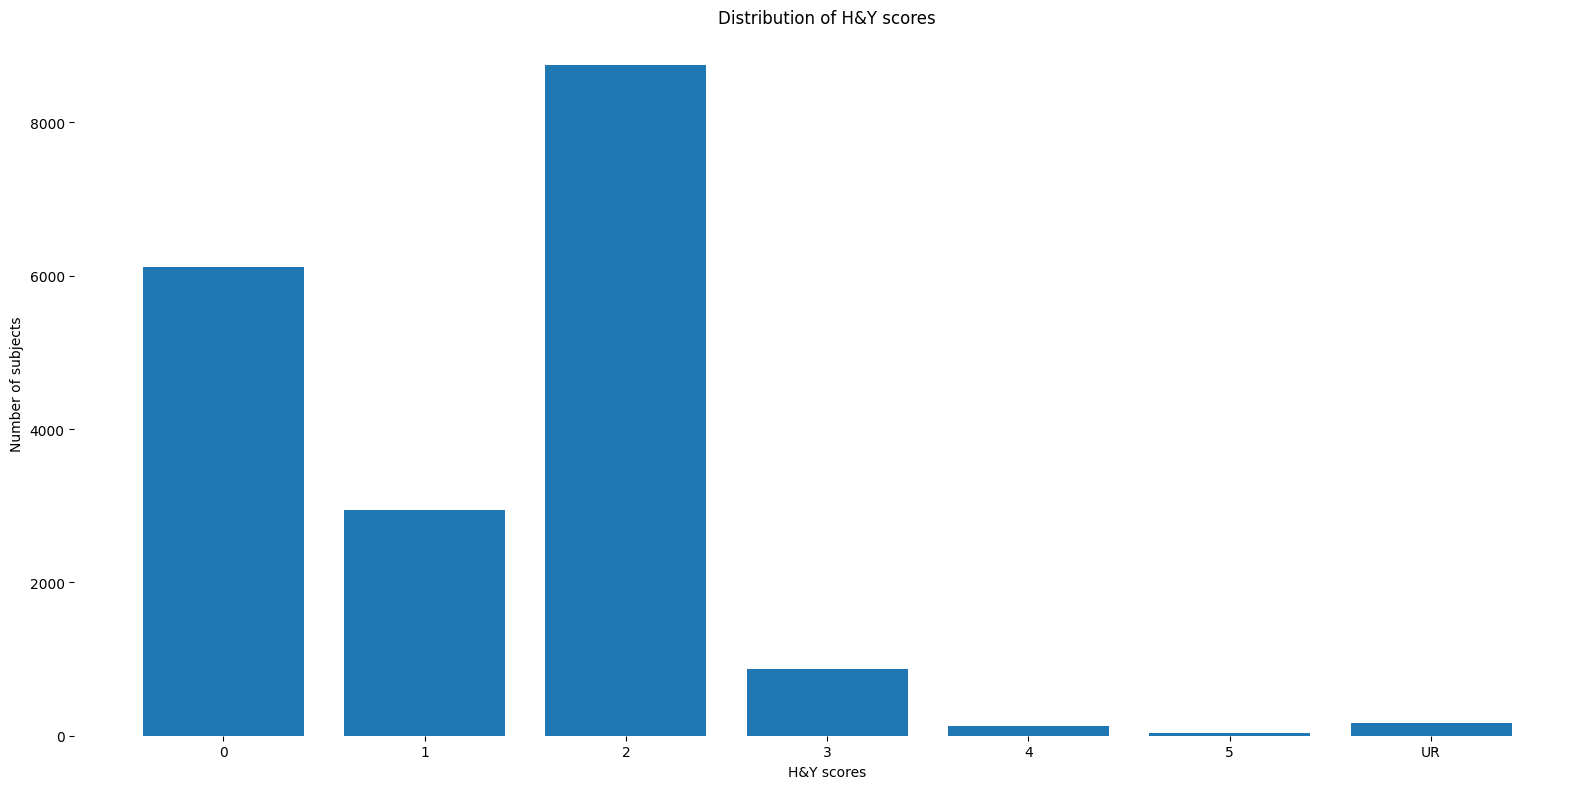

In [53]:
updrs3 = pd.read_csv(os.path.join(data_dir, "MDS_UPDRS_Part_III_clean.csv"))[
    ["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"]
]
updrs3 = updrs3[updrs3["NHY"].notna()]

dist = updrs3.groupby(["NHY"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of H&Y scores")
plt.xlabel("H&Y scores")
plt.ylabel("Number of subjects");

We remove the patients for which clinicians were unable to rate the H&Y score (UR).

In [54]:
updrs3 = updrs3[updrs3["NHY"] != "UR"]
updrs3["NHY"] = pd.to_numeric(updrs3["NHY"])

### Unified Parkinson's Disease Rating Scale, Part III (UPDRS III)

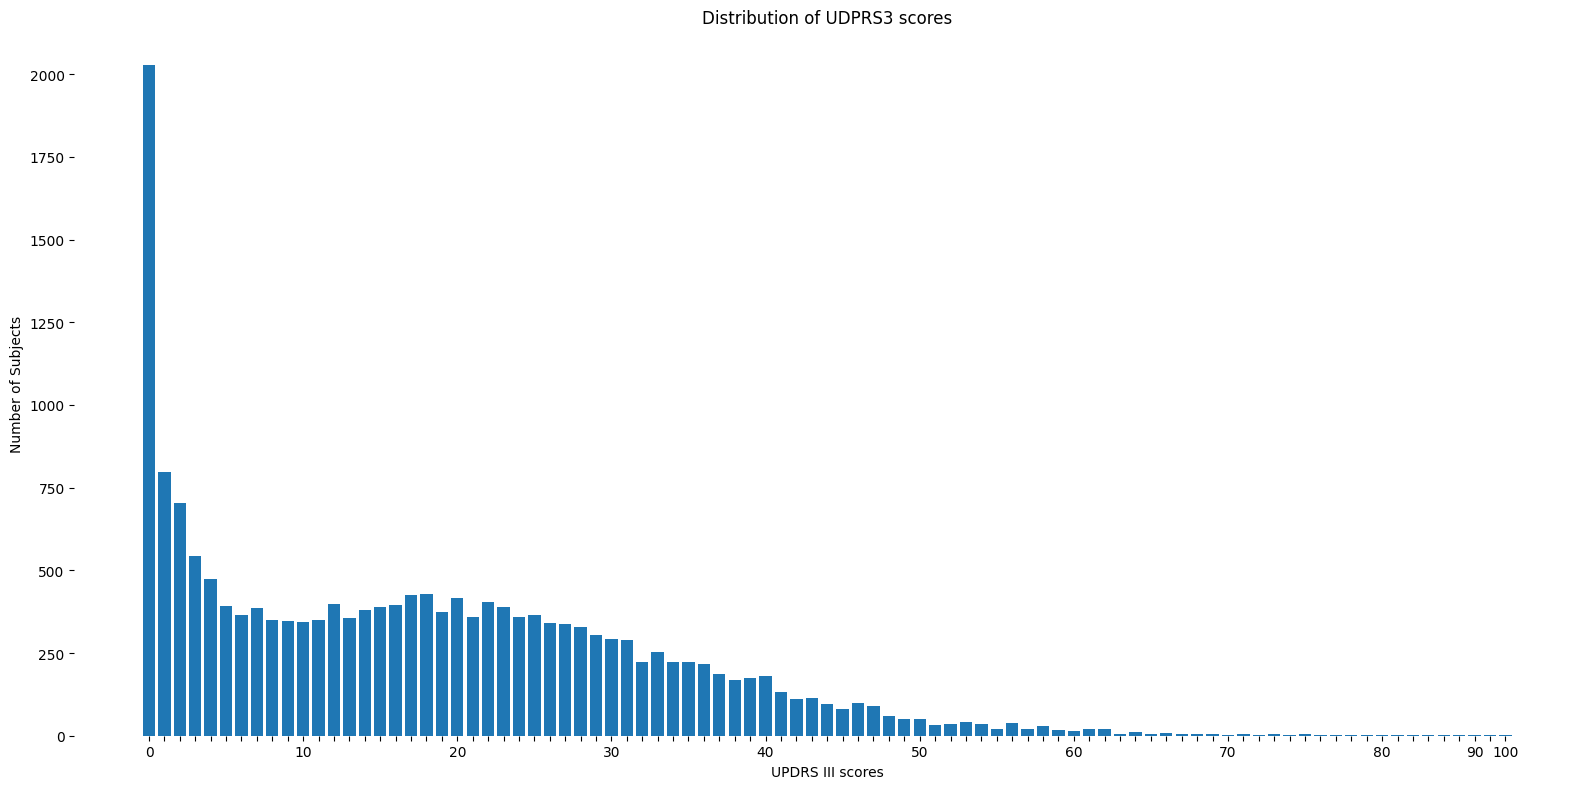

In [55]:
fig, ax = plt.subplots()

dist = updrs3.groupby(["NP3TOT"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of UDPRS3 scores")
plt.xlabel("UPDRS III scores")
plt.ylabel("Number of Subjects")

reformat_plot_labels(dist, ax, 10)

### Geriatric Depression Scale Short version (GDS)
Due to the absence of data on Hamilton Depression Scale, we will be using Geriatric Depression Scale. 

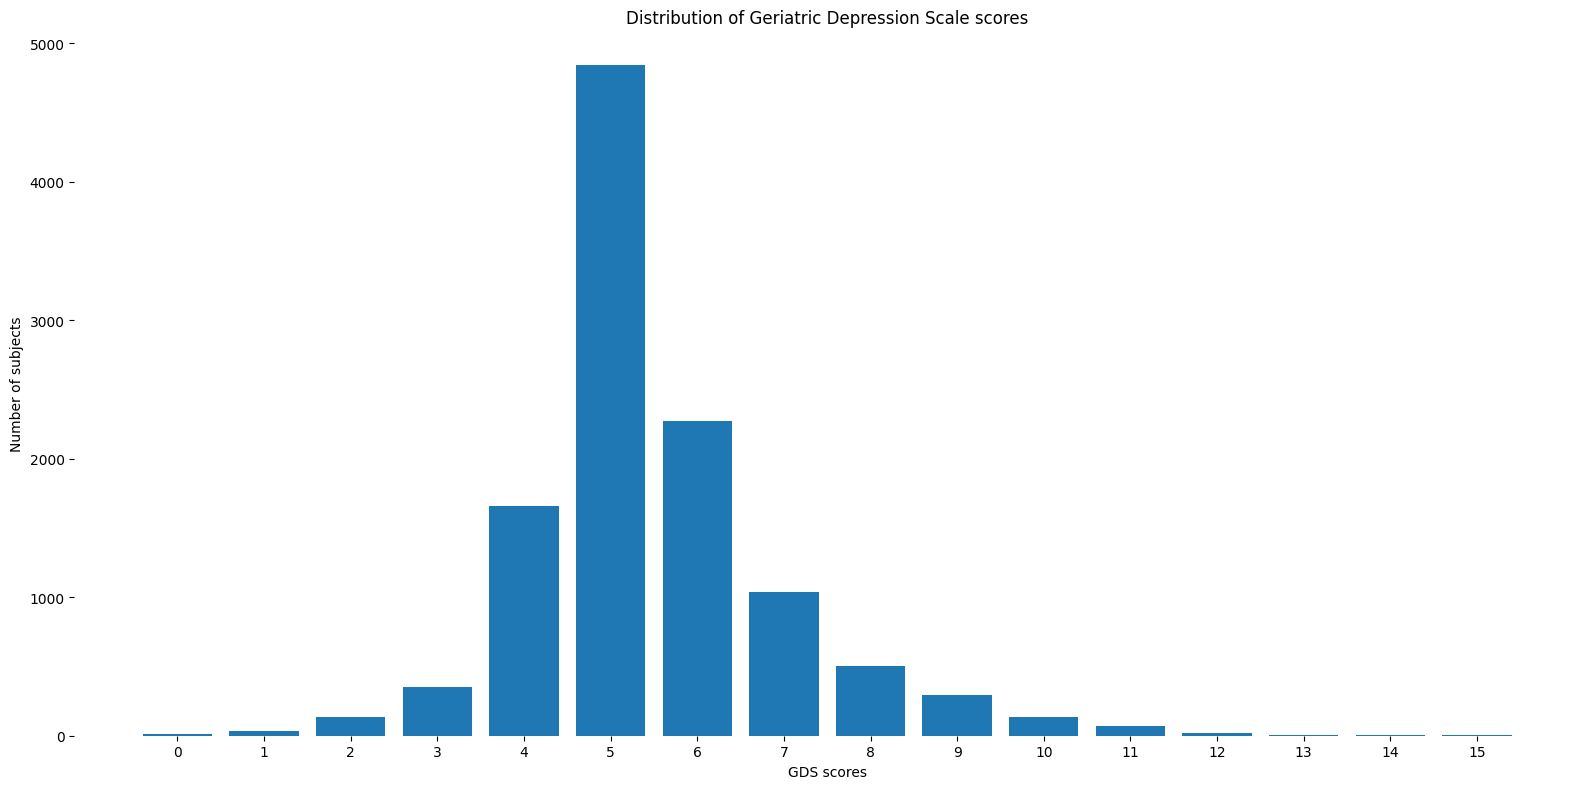

In [56]:
gds = pd.read_csv(
    os.path.join(inputs_dir, "Geriatric_Depression_Scale__Short_Version_.csv")
)
gds["GDSTOT"] = gds.drop(
    ["PATNO", "EVENT_ID", "REC_ID", "PAG_NAME", "INFODT", "LAST_UPDATE", "ORIG_ENTRY"],
    axis=1,
).sum(axis=1)
gds = gds[["PATNO", "EVENT_ID", "GDSTOT"]]

dist = gds.groupby(["GDSTOT"]).size()
plt.bar(dist.index.astype(int).astype(str), dist.values)
plt.title("Distribution of Geriatric Depression Scale scores")
plt.xlabel("GDS scores")
plt.ylabel("Number of subjects");

### Levodopa daily equivalent dosage (LEDD)

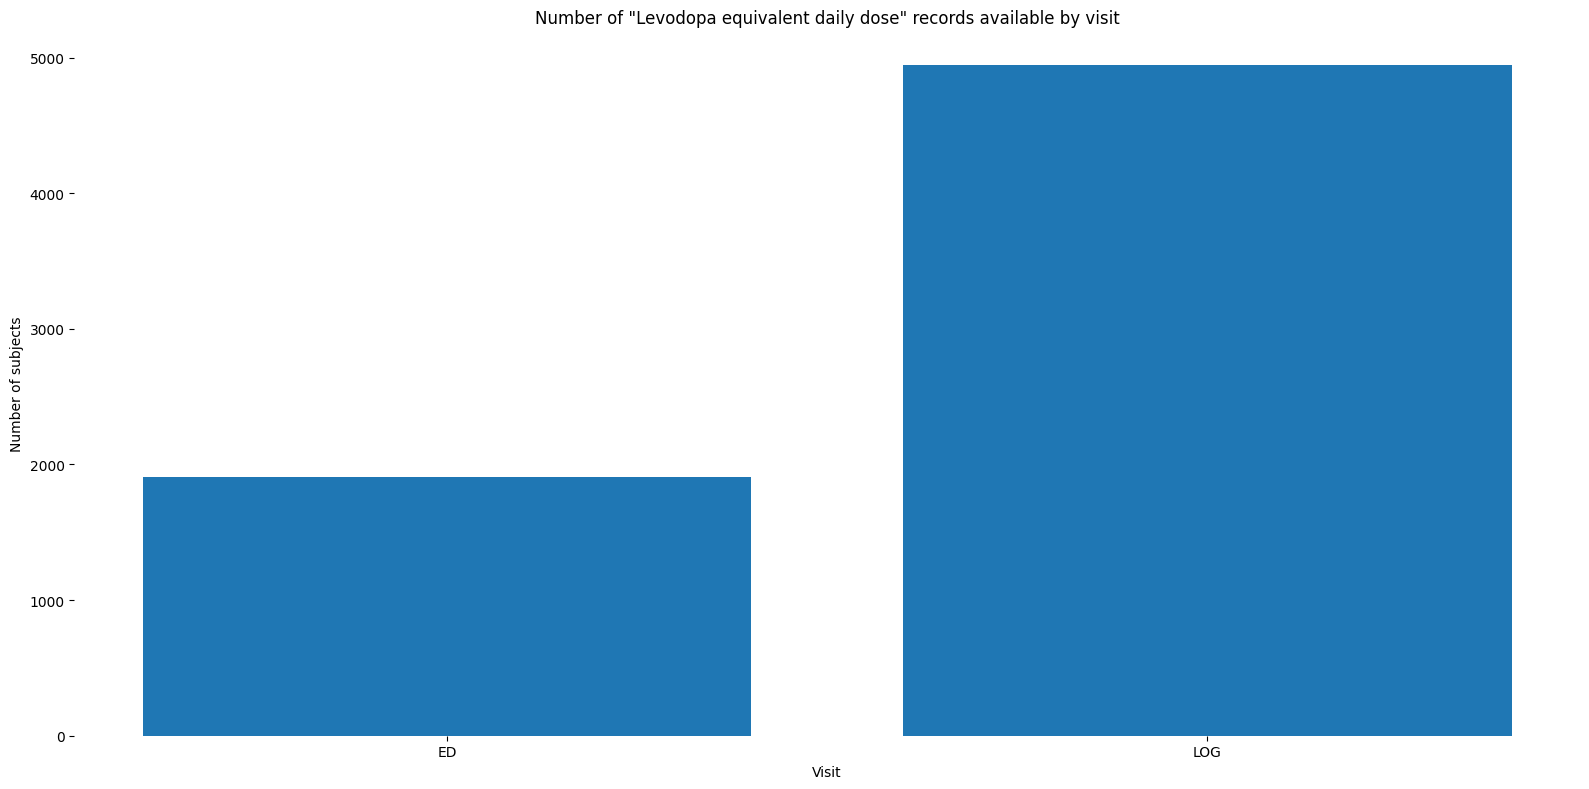

In [57]:
ledd = pd.read_csv(os.path.join(inputs_dir, "LEDD_Concomitant_Medication_Log.csv"))[
    ["PATNO", "EVENT_ID", "LEDD"]
]

dist = ledd.groupby(["EVENT_ID"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title('Number of "Levodopa equivalent daily dose" records available by visit')
plt.xlabel("Visit")
plt.ylabel("Number of subjects");

We will only use LEDD data recorded at logs since it is by far the most frequent.

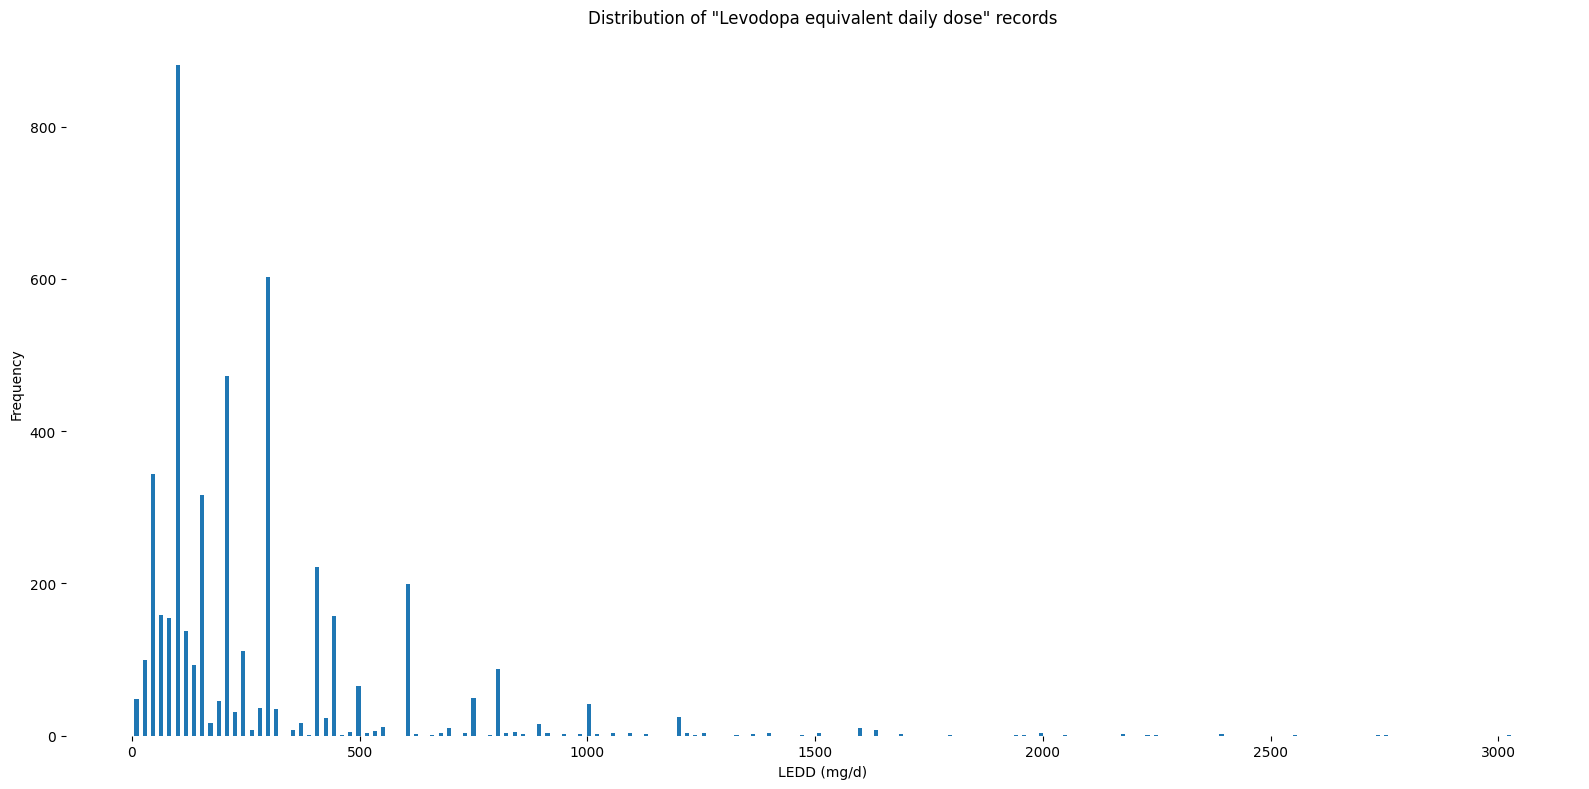

In [58]:
ledd = ledd[ledd["EVENT_ID"] == "LOG"]
ledd = ledd[["PATNO", "LEDD"]]

# For PD medications except COMT inhibitors, the column LEDD will show the value of the
# Levodopa equivalent dose for that medication.

# For COMT inhibitors, the column LEDD will read “LD x 0.33” (for Entacapone) or “LD x 0.5”
# (for Tolcapone).

# To find the LEDD for COMT inhibitors, first find the total dose of Levodopa only,
# and then multiply the Levodopa dose by either 0.33 or 0.5 as instructed.

# Since Levodopa dose is mostly missing we will drop those.

ledd = ledd[ledd["LEDD"].notna()]  # Drop nan
ledd = ledd[ledd["LEDD"] != "LD x 0.33"]  # Drop LD x 0.33
ledd = ledd[ledd["LEDD"] != "LD x 0.5"]  # Drop LD x 0.5

ledd["LEDD"] = ledd["LEDD"].astype("float32")

dist = ledd.groupby(["LEDD"]).size()

plt.hist(ledd["LEDD"], zorder=3, bins=len(dist.index), rwidth=0.5)
plt.title('Distribution of "Levodopa equivalent daily dose" records')
plt.xlabel("LEDD (mg/d)")
plt.ylabel("Frequency");

### Demographics

### Sex

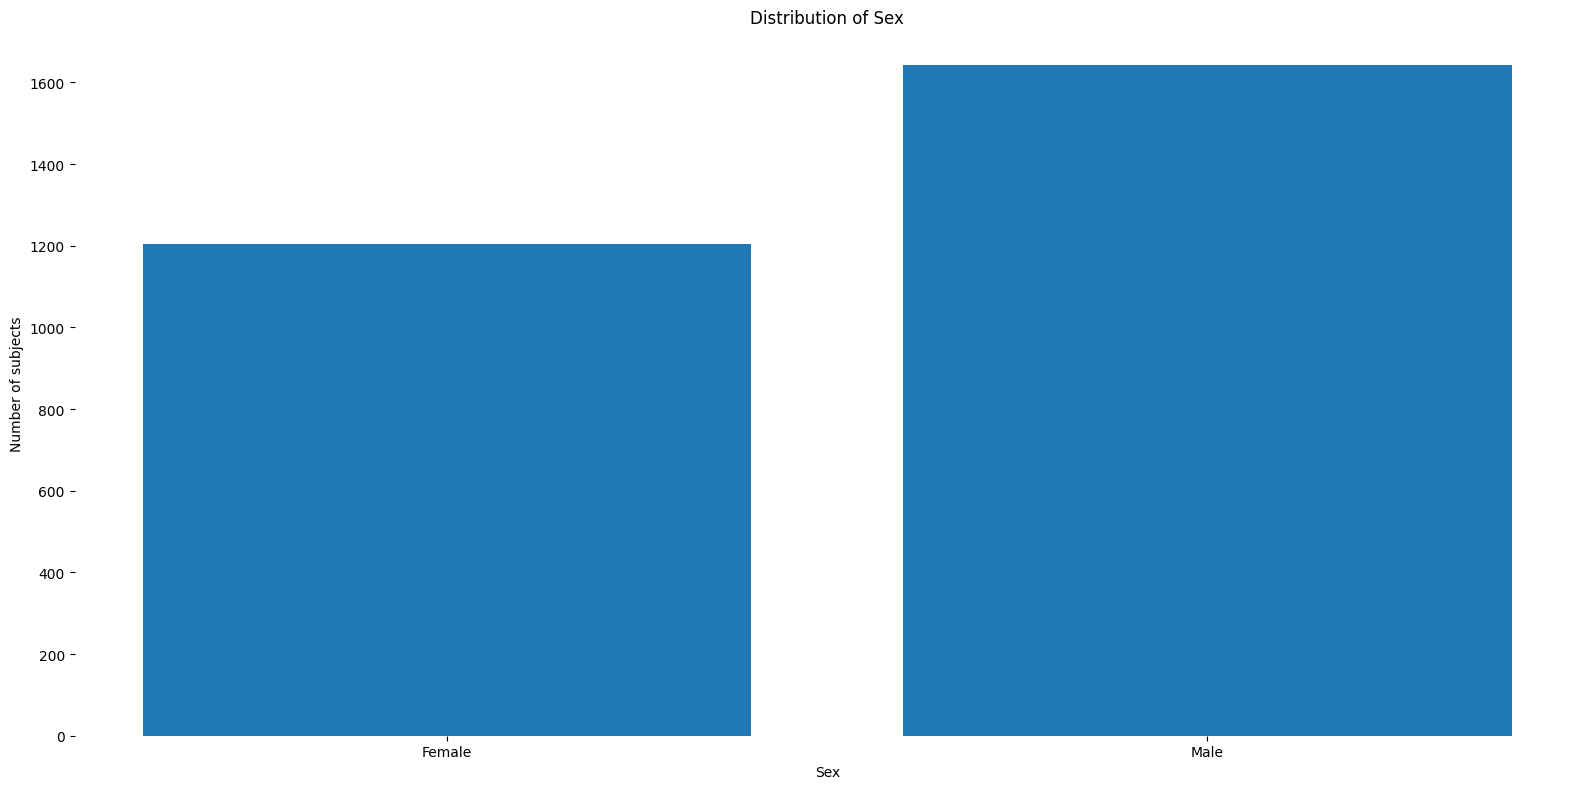

In [59]:
sex = pd.read_csv(os.path.join(inputs_dir, "Demographics.csv"))[["PATNO", "SEX"]]
sex["SEX"] = sex["SEX"].astype(int)

dist = sex.groupby("SEX").size().rename({0: "Female", 1: "Male"})
plt.bar(dist.index, dist.values)
plt.title("Distribution of Sex")
plt.xlabel("Sex")
plt.ylabel("Number of subjects");

### Age at visit
We consider the age at specific visits (baseline and 36 months). However for simplicity, we only plot the age distribution at baseline.

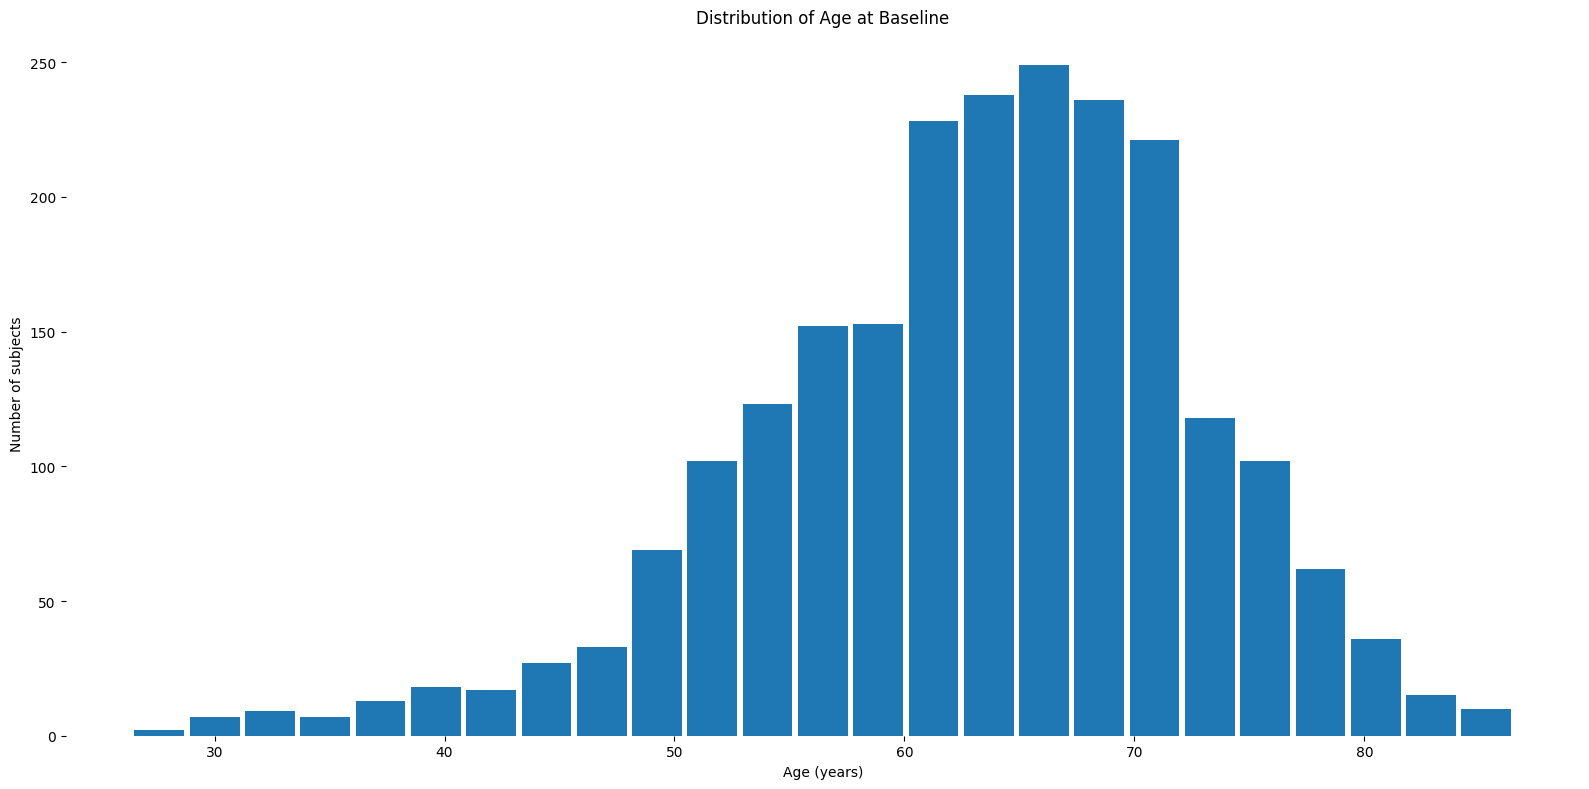

In [60]:
age = pd.read_csv(os.path.join(inputs_dir, "Age_at_visit.csv"))[
    ["PATNO", "EVENT_ID", "AGE_AT_VISIT"]
]

age[age["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(
    bins=25, title="Distribution of Age at Baseline", rwidth=0.9
)
plt.xlabel("Age (years)")
plt.ylabel("Number of subjects");

### Education
We only use the education years at screening as most of the other visits do not have records of it and most likely didn't change. In addition, when present, the education years at further visits showed inconsistency limiting the possibility to perform data imputation.

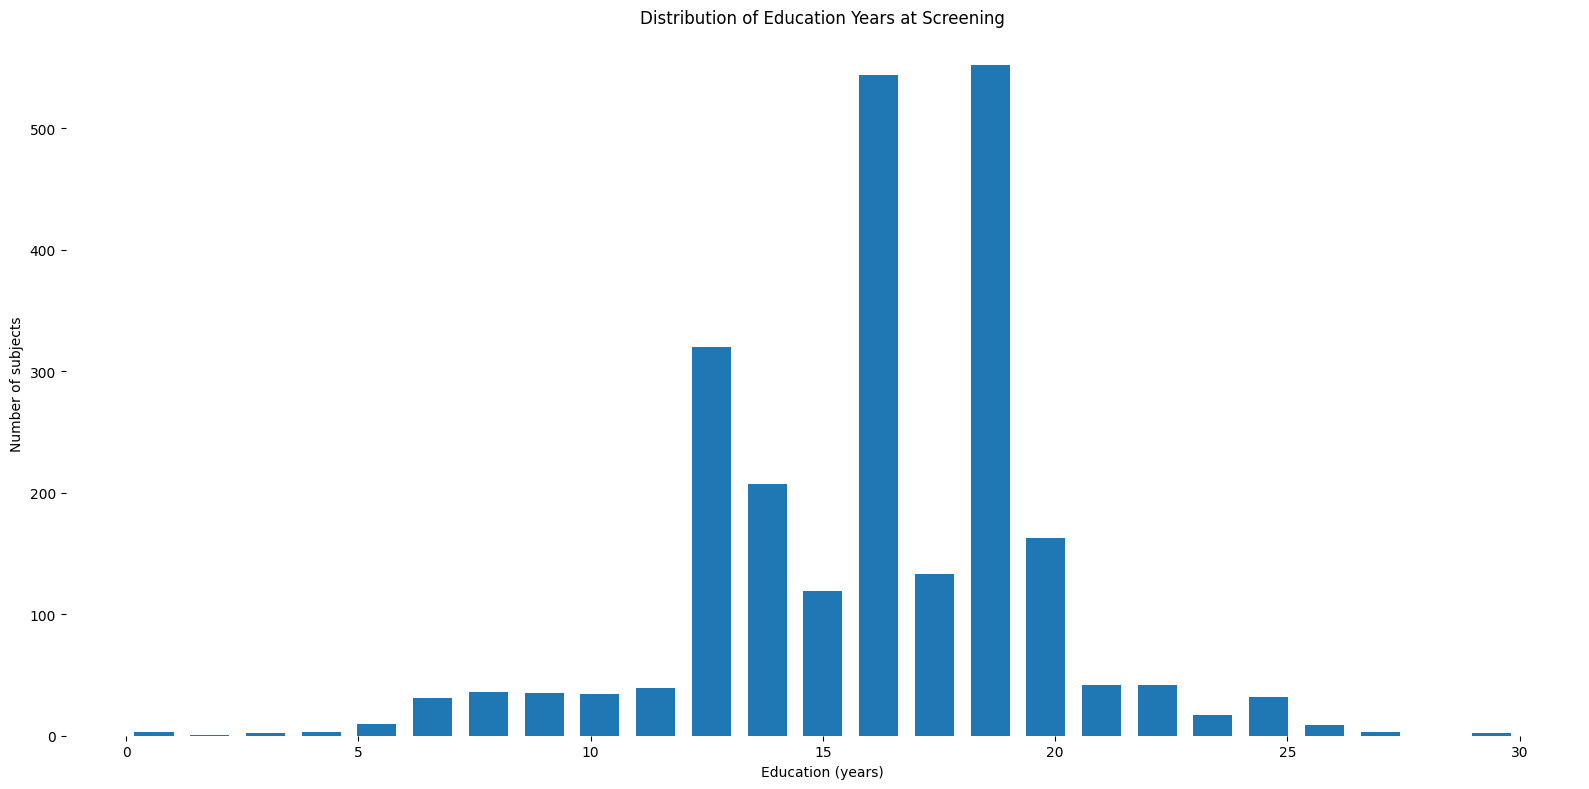

In [61]:
edu = pd.read_csv(os.path.join(inputs_dir, "Socio-Economics.csv"))[
    ["PATNO", "EVENT_ID", "EDUCYRS"]
]
edu = edu[edu["EVENT_ID"] == "SC"].drop(["EVENT_ID"], axis=1)

edu["EDUCYRS"].plot.hist(bins=25, rwidth=0.7)
plt.title("Distribution of Education Years at Screening")
plt.xlabel("Education (years)")
plt.ylabel("Number of subjects");

### MRI Availability

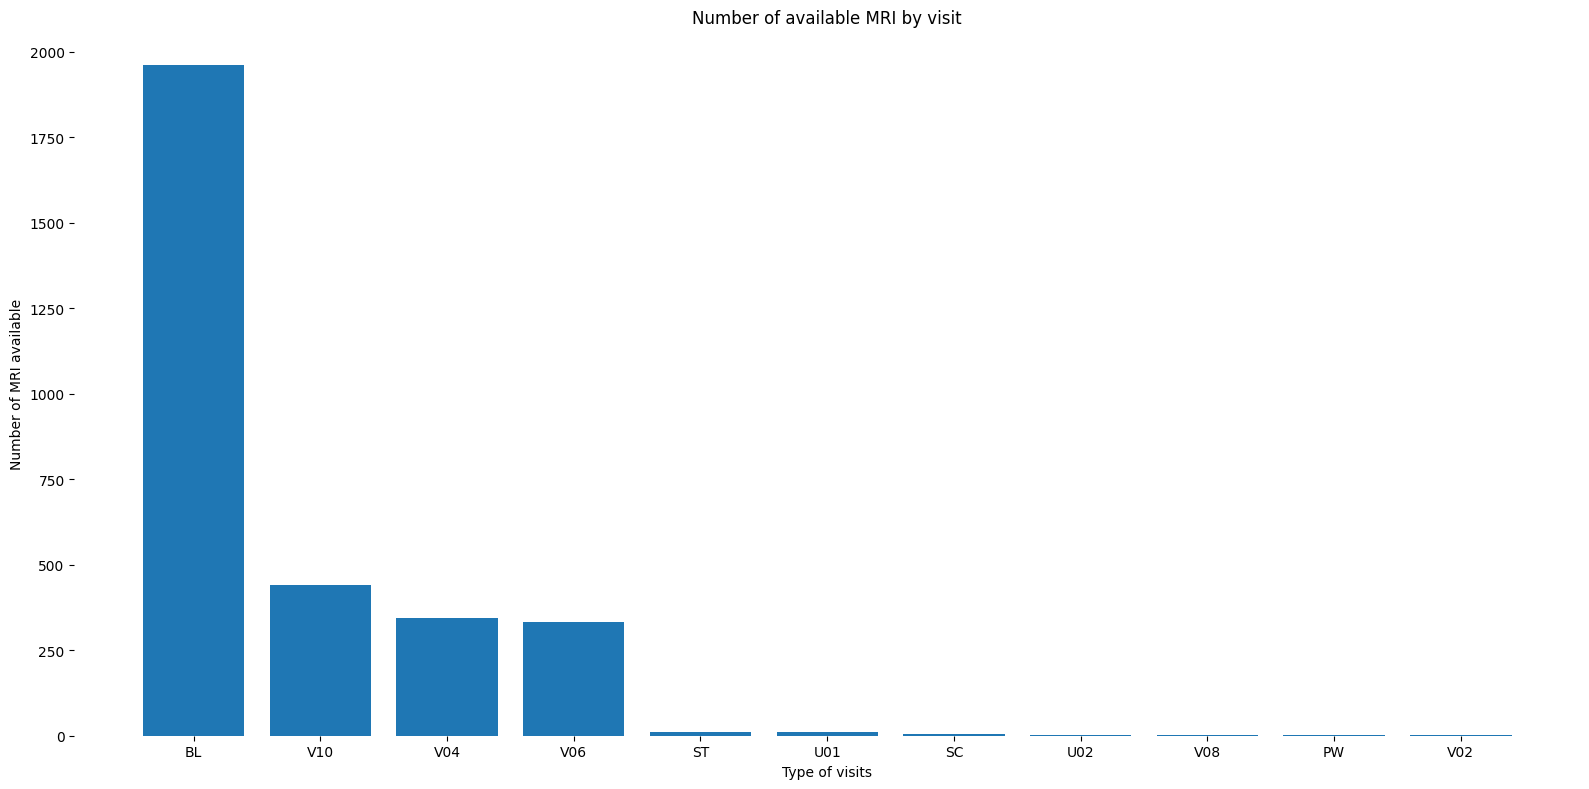

In [62]:
mri = pd.read_csv(os.path.join(data_dir, "MRI_info.csv"))[
    ["Visit code", "Subject ID", "Sex"]
]
mri["EVENT_ID"] = mri["Visit code"]
mri["PATNO"] = mri["Subject ID"]
mri["Sex"] = mri["Sex"].map({"F": 0, "M": 1})

mri.drop(["Visit code", "Subject ID", "Sex"], axis=1)

dist = mri.groupby("EVENT_ID").size().sort_values(ascending=False)

plt.bar(dist.index, dist.values)
plt.title("Number of available MRI by visit")
plt.xlabel("Type of visits")
plt.ylabel("Number of MRI available");

### Data aggregation
We merge the data processed above to obtain a set of data with available:
- Duration of illness
- MMSE, H&Y, UPDRS III, and GDS scores
- Levodopa equivalent dosage
- Sex, age at visit, and education

### PD patients

In [63]:
keys = ["PATNO", "EVENT_ID"]
pd_df = (
    participants[participants["COHORT"] == 1]
    .merge(mmse)
    .merge(pdxdur, on=keys)
    .merge(updrs3, on=keys)
    .merge(gds, on=keys)
    .merge(ledd, on=["PATNO"])
    .merge(sex, on=["PATNO"])
    .merge(age, on=keys)
    .merge(edu, on=["PATNO"])
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda x: x["EVENT_ID"].nunique() > 1)
)

pde_patno = pd_df[pd_df["DOI"] == "PD-early"]["PATNO"]
pdm_patno = pd_df[pd_df["DOI"] == "PD-middle"]["PATNO"]
pdl_patno = pd_df[pd_df["DOI"] == "PD-late"]["PATNO"]

In [64]:
print("Unique number of patients:", pd_df["PATNO"].nunique())
print("Unique number of patients with PD-early:", pde_patno.nunique())
print("Unique number of patients with PD-middle:", pdm_patno.nunique())
print("Unique number of patients with PD-late:", pdl_patno.nunique())

print("\n" + pd_df.groupby(["DOI", "EVENT_ID"])["PATNO"].nunique().to_string())

Unique number of patients: 557
Unique number of patients with PD-early: 1
Unique number of patients with PD-middle: 506
Unique number of patients with PD-late: 433

DOI        EVENT_ID
PD-early   V04           1
PD-late    ST            1
           V04          46
           V05           1
           V06          60
           V08          60
           V10          87
           V12         118
           V13         272
           V14         244
           V15         137
           V16          98
           V17          82
           V18          27
PD-middle  ST           42
           U01           1
           V03           1
           V04         447
           V05           1
           V06         433
           V08         403
           V10         330
           V12         254


<div class="alert alert-block alert-danger">
Problem: Merging GDS scores brings the number of PD-early patients down close to zero.
</div>

<div class="alert alert-block alert-success">
Solution: We can ignore GDS scores since it's not part of the inclusion criteria and it was a replacement for the Hamilton Depression Scale 
</div>

In [65]:
keys = ["PATNO", "EVENT_ID"]
pd_df = (
    participants[participants["COHORT"] == 1]
    .merge(mmse)
    .merge(pdxdur, on=keys)
    .merge(updrs3, on=keys)
    .merge(ledd, on=["PATNO"])
    .merge(sex, on=["PATNO"])
    .merge(age, on=keys)
    .merge(edu, on=["PATNO"])
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda x: x["EVENT_ID"].nunique() > 1)
)

pde_patno = pd_df[pd_df["DOI"] == "PD-early"]["PATNO"]
pdm_patno = pd_df[pd_df["DOI"] == "PD-middle"]["PATNO"]
pdl_patno = pd_df[pd_df["DOI"] == "PD-late"]["PATNO"]

In [66]:
print("After removing GDS scores:")
print("Unique number of patients:", pd_df["PATNO"].nunique())
print("Unique number of patients with PD-early:", pde_patno.nunique())
print("Unique number of patients with PD-middle:", pdm_patno.nunique())
print("Unique number of patients with PD-late:", pdl_patno.nunique())

print("\n" + pd_df.groupby(["DOI", "EVENT_ID"])["PATNO"].nunique().to_string())

After removing GDS scores:
Unique number of patients: 604
Unique number of patients with PD-early: 365
Unique number of patients with PD-middle: 563
Unique number of patients with PD-late: 438

DOI        EVENT_ID
PD-early   SC          365
           V01           1
           V03           1
           V04           1
PD-late    SC           18
           ST            1
           V04          49
           V05           1
           V06          61
           V08          62
           V10          88
           V12         119
           V13         273
           V14         245
           V15         138
           V16          98
           V17          82
           V18          27
PD-middle  PW            1
           SC          156
           ST           43
           U01           1
           V03           1
           V04         481
           V05           1
           V06         437
           V08         407
           V10         331
           V12         254


<div class="alert alert-block alert-info">
Note: Patients are divided into subgroups at baseline and can not transition from one subgroup to another in the following visits.
</div>

<div class="alert alert-block alert-danger">
Problem: There isn't any patient data available at baseline.
</div>

<div class="alert alert-block alert-success">
Solution: We can use data at screening as substitute for baseline.
</div>

In [67]:
pd_df["EVENT_ID"].mask(pd_df["EVENT_ID"] == "SC", "BL", inplace=True)
print(
    "After Substitution:\n\n"
    + pd_df.groupby(["DOI", "EVENT_ID"])["PATNO"].nunique().to_string()
)

After Substitution:

DOI        EVENT_ID
PD-early   BL          365
           V01           1
           V03           1
           V04           1
PD-late    BL           18
           ST            1
           V04          49
           V05           1
           V06          61
           V08          62
           V10          88
           V12         119
           V13         273
           V14         245
           V15         138
           V16          98
           V17          82
           V18          27
PD-middle  BL          156
           PW            1
           ST           43
           U01           1
           V03           1
           V04         481
           V05           1
           V06         437
           V08         407
           V10         331
           V12         254


<div class="alert alert-block alert-danger">
Problem: The number of patients at baseline in PD<sub>L</sub> is lower than the initial study (24).
</div>

<div class="alert alert-block alert-success">
Solution: We can use another visit with sufficient number of patients as baseline and adjust the 36 month follow up accordingly.
</div>

### Healthy controls

In [68]:
keys = ["PATNO", "EVENT_ID"]
hc_df = (
    mmse.merge(participants[participants["COHORT"] == 2], on=["PATNO"])
    .merge(sex, on=["PATNO"])
    .merge(age, on=keys)
    .merge(edu, on=["PATNO"])
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda x: x["EVENT_ID"].nunique() > 1)
)

print("Number of healthy control participants:\n")
print(hc_df.groupby("EVENT_ID")["PATNO"].nunique().to_string())

Number of healthy control participants:

EVENT_ID
SC     205
V04    201
V06    173
V08    165
V10    159
V12    153
V13     23
V14    105
V15     90
V16     39
V17     61
V18     51
V19      8


<div class="alert alert-block alert-danger">
Problem: There isn't any healthy control data available at baseline.
</div>

<div class="alert alert-block alert-success">
Solution: We can use data at screening as substitute for baseline.
</div>

In [69]:
hc_df["EVENT_ID"].mask(hc_df["EVENT_ID"] == "SC", "BL", inplace=True)
print(
    "After Substitution:\n\n" + hc_df.groupby("EVENT_ID")["PATNO"].nunique().to_string()
)

After Substitution:

EVENT_ID
BL     205
V04    201
V06    173
V08    165
V10    159
V12    153
V13     23
V14    105
V15     90
V16     39
V17     61
V18     51
V19      8


### Cohort sampling
We replicate the table from the initial study with the PPMI data.

In [70]:
random_state = 123


def closest_average(numbers, k, avg):
    numbers = sorted(numbers)

    current_sum = sum(numbers[:k])
    current_selection = numbers[:k]

    best_selection = current_selection
    best_avg = current_sum / k

    for i in range(k, len(numbers)):
        next_avg = (current_sum - current_selection[0] + numbers[i]) / k

        if abs(next_avg - avg) < abs(best_avg - avg):
            current_sum = current_sum - current_selection[0] + numbers[i]
            current_selection = current_selection[1:] + [numbers[i]]

            if abs(next_avg - avg) < abs(best_avg - avg):
                best_selection = current_selection.copy()
                best_avg = next_avg

    return best_selection


def sample_cohort(df, n_f, n_m, avg, random_state=random_state):
    _df = (
        df.sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
        .drop_duplicates(subset=["PATNO"])
    )
    df_f = _df[_df["SEX"] == 0]
    df_m = _df[_df["SEX"] == 1]
    n_f, n_m = min(df_f.index.size, n_f), min(df_m.index.size, n_m)
    ls_f = df_f["AGE_AT_VISIT"].values.tolist()
    ls_m = df_m["AGE_AT_VISIT"].values.tolist()

    subset_f = closest_average(ls_f, n_f, avg)
    df_f = df_f[df_f["AGE_AT_VISIT"].isin(subset_f)].sample(
        n=n_f, replace=False, random_state=random_state
    )
    subset_m = closest_average(ls_m, n_m, avg)
    df_m = df_m[df_m["AGE_AT_VISIT"].isin(subset_m)].sample(
        n=n_m, replace=False, random_state=random_state
    )

    return pd.concat([df_f, df_m])


def sample_followup(df, sample_df, event_id, n_f, n_m, random_state=random_state):
    _df = (
        df[(df["PATNO"].isin(sample_df["PATNO"])) & (df["EVENT_ID"] == event_id)]
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
        .drop_duplicates(subset=["PATNO"])
    )

    df_f = _df[_df["SEX"] == 0]
    df_m = _df[_df["SEX"] == 1]
    n_f, n_m = min(df_f.index.size, n_f), min(df_m.index.size, n_m)
    df_f = df_f.sample(n=n_f, replace=False, random_state=random_state)
    df_m = df_m.sample(n=n_m, replace=False, random_state=random_state)

    return pd.concat([df_f, df_m])

In [71]:
# PD patients

# PD early
pde_followup_event = "V08"
pde_df = pd_df[
    pd_df["PATNO"].isin(pd_df[pd_df["EVENT_ID"] == "BL"]["PATNO"])
    & pd_df["PATNO"].isin(pd_df[pd_df["EVENT_ID"] == pde_followup_event]["PATNO"])
]
pde_bl = sample_cohort(
    pde_df[pde_df["DOI"] == "PD-early"],
    n_f=12,
    n_m=5,
    avg=60.9,
)
pde_36 = sample_followup(pd_df, pde_bl, pde_followup_event, n_f=7, n_m=3)


# PD middle
pdm_followup_event = "V08"
pdm_df = pd_df[
    pd_df["PATNO"].isin(pd_df[pd_df["EVENT_ID"] == "BL"]["PATNO"])
    & pd_df["PATNO"].isin(pd_df[pd_df["EVENT_ID"] == pdm_followup_event]["PATNO"])
]
pdm_bl = sample_cohort(
    pdm_df[
        (pdm_df["DOI"] == "PD-middle") & ~pdm_df["PATNO"].isin(pde_bl["PATNO"].unique())
    ],
    n_f=9,
    n_m=20,
    avg=61.3,
)
pdm_36 = sample_followup(pd_df, pdm_bl, pdm_followup_event, n_f=8, n_m=15)


# PD late
pdl_bl_event = "V04"
pdl_followup_event = "V10"
pdl_df = pd_df[
    pd_df["PATNO"].isin(pd_df[pd_df["EVENT_ID"] == pdl_bl_event]["PATNO"])
    & pd_df["PATNO"].isin(pd_df[pd_df["EVENT_ID"] == pdl_followup_event]["PATNO"])
]
pdl_bl = sample_cohort(
    pdl_df[
        (pdl_df["DOI"] == "PD-late")
        & ~pdl_df["PATNO"].isin(pde_bl["PATNO"].unique())
        & ~pdl_df["PATNO"].isin(pdm_bl["PATNO"].unique())
    ],
    n_f=9,
    n_m=15,
    avg=65,
)
pdl_36 = sample_followup(pd_df, pdl_bl, pdl_followup_event, n_f=7, n_m=8)

pd_bl = pd.concat([pde_bl, pdm_bl, pdl_bl])
pd_36 = pd.concat([pde_36, pdm_36, pdl_36])

# Healthy controls
hc_followup_event = "V08"
hc_bl = sample_cohort(hc_df[hc_df["EVENT_ID"] == "BL"], n_f=35, n_m=35, avg=61.3)
hc_36 = sample_followup(hc_df, hc_bl, hc_followup_event, n_f=27, n_m=25)

## Cohort Summary

In [72]:
def cohort_summary(
    *, hc, pd, pde, pdm, pdl, hc_36, pd_36, pde_36, pdm_36, pdl_36, title
):
    def gen_row(D, *, agg, col, f="4.1f", sep=" ± "):
        if not isinstance(agg, str) and isinstance(agg, Iterable):
            return [f"{sep}".join([f"{d.loc[a][col]:{f}}" for a in agg]) for d in D]
        else:
            return [f"{d.loc[agg][col]:{f}}" for d in D]

    def gender(df):
        male = df[df["SEX"] == 1]["PATNO"].nunique()
        female = df[df["SEX"] == 0]["PATNO"].nunique()
        return f"{female+male}({female}, {male})"

    def get_super(x):
        normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
        super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
        res = x.maketrans("".join(normal), "".join(super_s))
        return x.translate(res)

    def get_sub(x):
        normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
        sub_s = "ₐ₈CDᴇբGₕᵢⱼₖₗᴍₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
        res = x.maketrans("".join(normal), "".join(sub_s))
        return x.translate(res)

    caption = f"""Abbreviations: DOI = duration of illness; H&Y = Hoen & Yahr; GDS = Geriatric Depression Scale; LEDD = levodopa daily equivalent dosage; MMSE = Mini-Mental State Examination; PD = Parkinson disease; PD{get_sub('E')} = Parkinsons disease-early; PD{get_sub('M')} = Parkinson disease-middle; PD{get_sub('L')} = Parkinson disease-late; UPDRS = Unified Parkinson's Disease Rating Scale.
Measurements presented as mean ± SD unless otherwise indicated.
{get_super("a")}𝑝 Values for comparisons between all PD and control participants using 2-sample t tests.
{get_super("b")}𝑝 Values of analysis of variance across PD subgroups (and controls as appropriate).
{get_super("c")}𝑝 Values obtained using Fisher exact test.
{get_super("d")}Statistically significant.
"""

    D = [hc.describe(), pd.describe(), pde.describe(), pdm.describe(), pdl.describe()]
    D_36 = [
        hc_36.describe(),
        pd_36.describe(),
        pde_36.describe(),
        pdm_36.describe(),
        pdl_36.describe(),
    ]

    table = Table(
        title=title,
        box=rich.box.SIMPLE_HEAVY,
        caption=caption,
        caption_justify="left",
    )

    table.add_column("")
    table.add_column("Control")
    table.add_column("PD overall")
    table.add_column("PD" + get_sub("E"))
    table.add_column("PD" + get_sub("M"))
    table.add_column("PD" + get_sub("L"))
    #     table.add_column('𝑝 Value' + get_super('a'))
    #     table.add_column('𝑝 Value' + get_super('b'))

    table.add_row("Longitudinal cohort participants")
    table.add_row("Baseline")
    table.add_row(
        "\tNo. participants (F, M)",
        gender(hc),
        gender(pd),
        gender(pde),
        gender(pdm),
        gender(pdl),
    )
    table.add_row("\tAge, y", *gen_row(D, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row("\tEducation, y", *gen_row(D, agg=["mean", "std"], col="EDUCYRS"))
    table.add_row("\tMMSE", *gen_row(D, agg=["mean", "std"], col="MMSETOT"))
    #     table.add_row('\tGDS', *gen_row(D, agg=["mean", "std"], col='GDSTOT'))
    table.add_row("\tDOI, y", "_", *gen_row(D[1:], agg=["mean", "std"], col="PDXDUR"))
    table.add_row("\tLEDD, mg", "_", *gen_row(D[1:], agg=["mean", "std"], col="LEDD"))
    table.add_row(
        "\tUPDRS-III", "_", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT")
    )
    table.add_row("\tH&Y stage", "_", *gen_row(D[1:], agg=["mean", "std"], col="NHY"))

    table.add_row("36 months")
    table.add_row(
        "\tNo. participants (F, M)",
        gender(hc_36),
        gender(pd_36),
        gender(pde_36),
        gender(pdm_36),
        gender(pdl_36),
    )
    table.add_row("\tAge, y", *gen_row(D_36, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row("\tEducation, y", *gen_row(D_36, agg=["mean", "std"], col="EDUCYRS"))
    #     table.add_row('\tGDS', *gen_row(D, agg=["mean", "std"], col='GDSTOT'))
    table.add_row(
        "\tDOI, y", "_", *gen_row(D_36[1:], agg=["mean", "std"], col="PDXDUR")
    )
    table.add_row(
        "\tLEDD, mg", "_", *gen_row(D_36[1:], agg=["mean", "std"], col="LEDD")
    )
    table.add_row(
        "\tUPDRS-III", "_", *gen_row(D_36[1:], agg=["mean", "std"], col="NP3TOT")
    )
    table.add_row(
        "\tH&Y stage", "_", *gen_row(D_36[1:], agg=["mean", "std"], col="NHY")
    )
    #     table.add_row('Validation study subjects')
    #     table.add_row('\tNo. participants (F, M)')
    #     table.add_row('\tAge, y')
    #     table.add_row('\tEducation, y')
    #     table.add_row('\tMMSE')
    #     table.add_row('\tGDS')
    #     table.add_row('\tDOI, y')
    #     table.add_row('\tLEDD, mg')
    #     table.add_row('\tUPDRS-III')
    #     table.add_row('\tH&Y stage')

    console = Console()
    console.print(table)

In [73]:
cohort_summary(
    hc=hc_bl,
    pd=pd_bl,
    pde=pde_bl,
    pdm=pdm_bl,
    pdl=pdl_bl,
    hc_36=hc_36,
    pd_36=pd_36,
    pde_36=pde_36,
    pdm_36=pdm_36,
    pdl_36=pdl_36,
    title="Demographic and clinical properties of study participants",
)

                            Demographic and clinical properties of study participants                             
                                                                                                                  
                                     Control       PD overall      PDᴇ             PDᴍ             PDₗ            
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Longitudinal cohort participants                                                                                
  Baseline                                                                                                        
          No. participants (F, M)    70(35, 35)    70(30, 40)      17(12, 5)       29(9, 20)       24(9, 15)      
          Age, y                     61.3 ±  3.4   62.5 ±  2.1     60.9 ±  0.6     61.3 ±  0.8     65.0 ±  1.2    
          Education, y               16.1 ±  2.8   15.4 ±  3.0     17.1 ±  2.2     14.2 ±  3.1     15.8 ±  2.8    
          MMSE                       29.7 ±  0.5   29.2 ±  1.0     29.3 ±  1.0     29.0 ±  1.1     29.4 ±  1.0    
          DOI, y                     _              3.9 ±  3.2      0.0 ±  0.0      3.3 ±  1.5      7.5 ±  1.5    
          LEDD, mg                   _             240.1 ± 210.7   178.0 ± 112.5   251.8 ± 228.5   269.7 ± 238.4  
          UPDRS-III                  _             23.9 ± 12.8     19.2 ± 10.5     25.7 ± 11.7     25.0 ± 15.1    
          H&Y stage                  _              1.9 ±  0.6      1.5 ±  0.5      2.0 ±  0.5      2.0 ±  0.7    
  36 months                                                                                                       
          No. participants (F, M)    52(27, 25)    48(22, 26)      10(7, 3)        23(8, 15)       15(7, 8)       
          Age, y                     64.6 ±  3.3   62.4 ±  2.2     63.8 ±  0.5     61.4 ±  1.8     62.9 ±  2.8    
          Education, y               16.2 ±  2.9   15.2 ±  3.1     17.3 ±  1.5     14.0 ±  3.3     15.7 ±  2.6    
          DOI, y                     _              4.0 ±  1.6      3.0 ±  0.0      3.7 ±  1.2      5.2 ±  1.9    
          LEDD, mg                   _             314.0 ± 371.0   170.6 ± 198.4   422.5 ± 464.5   243.3 ± 241.5  
          UPDRS-III                  _             26.5 ± 13.9     22.1 ± 14.6     28.5 ± 14.3     26.3 ± 12.9    
          H&Y stage                  _              2.0 ±  0.5      1.9 ±  0.6      1.9 ±  0.5      2.1 ±  0.6    
                                                                                                                  
Abbreviations: DOI = duration of illness; H&Y = Hoen & Yahr; GDS = Geriatric Depression Scale; LEDD = levodopa    
daily equivalent dosage; MMSE = Mini-Mental State Examination; PD = Parkinson disease; PDᴇ = Parkinsons           
disease-early; PDᴍ = Parkinson disease-middle; PDₗ = Parkinson disease-late; UPDRS = Unified Parkinson's Disease  
Rating Scale.                                                                                                     
Measurements presented as mean ± SD unless otherwise indicated.                                                   
ᵃ𝑝 Values for comparisons between all PD and control participants using 2-sample t tests.                         
ᵇ𝑝 Values of analysis of variance across PD subgroups (and controls as appropriate).                              
ᶜ𝑝 Values obtained using Fisher exact test.                                                                       
ᵈStatistically significant.                                                                                       
                                                                                                                  